In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [185]:
df = pd.read_csv('telco.csv')

In [186]:
df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [187]:
churn = df['Churn Label'].value_counts().to_frame().reset_index().set_axis(['churn', 'count'], axis= 1)
churn['percentage'] = churn.apply(lambda x: round(x['count']*100/churn['count'].sum(),2), axis = 1)

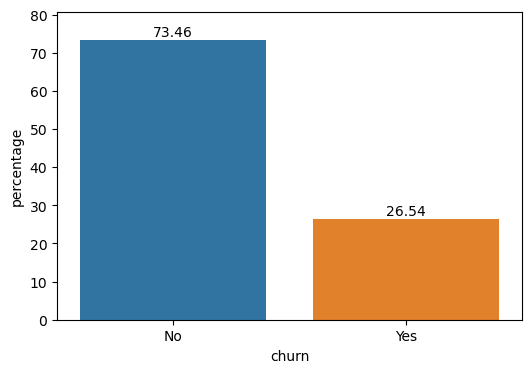

In [188]:
# Plotting and annotating using seaborn
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=churn['churn'], y=churn['percentage'], ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.show()

In [189]:
# Exploring churn wrt churn reason and satisfaction score
df_not_churned = df[df['Churn Label'] == 'No'].reset_index(drop=True)
df_churned = df[df['Churn Label'] == 'Yes'].reset_index(drop=True)

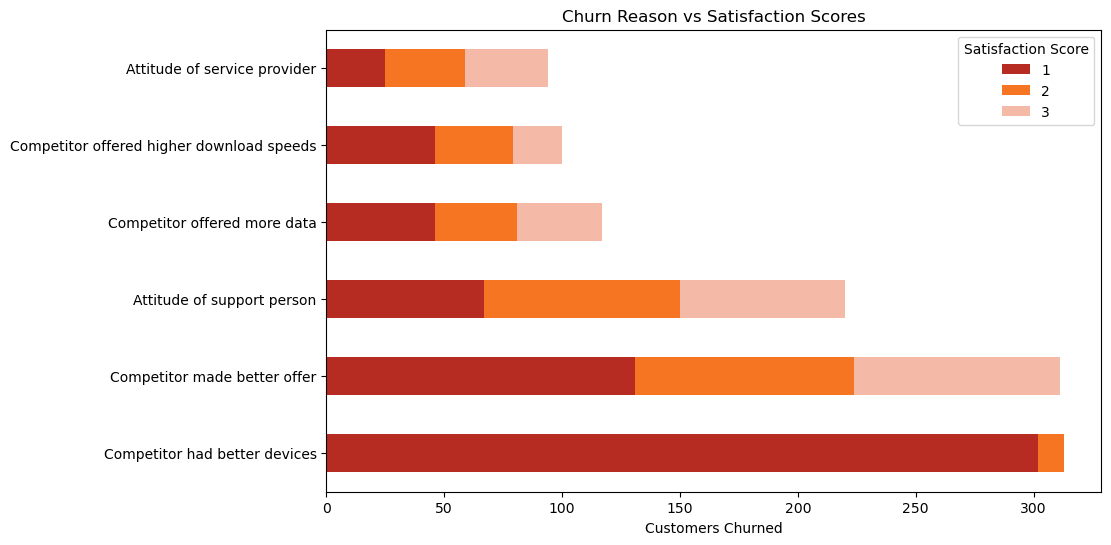

In [190]:
#Filter for valid churn reasons
df_filtered = df_churned[df_churned['Churn Reason'] != 'Don\'t know']

df_grouped = pd.pivot_table(df_filtered, index = ['Churn Reason'], columns=['Satisfaction Score'], aggfunc='size')
df_grouped = df_grouped.loc[df_grouped.sum(axis=1).sort_values(ascending=False).index]

custom_colors = ['#B62B22','#F57522','#F5B9A8']

# Plotting graph
df_grouped.head(6).plot(kind='barh', stacked=True, figsize=(10, 6), color = custom_colors)

plt.title('Churn Reason vs Satisfaction Scores')
plt.xlabel('Customers Churned')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend(title='Satisfaction Score')
plt.show()

In [191]:
# Exploring Churn based on Geographical Region

# Separating geographical data
print(df_churned['City'].value_counts().sort_values(ascending=False).head(20).to_markdown())


df_geos = df[['Zip Code','Latitude','Longitude','State','City','Population']].drop_duplicates()
df_churn_density = df_churned['Zip Code'].value_counts().reset_index().rename(columns={'index': 'Zip Code','Zip Code': 'Churn'})
df_not_churned_density = df_not_churned['Zip Code'].value_counts().reset_index().rename(columns={'index': 'Zip Code','Zip Code': 'Not Churn'})

df_geo_churn = pd.merge(
    left = pd.merge(left = df_geos, right = df_churn_density, on = 'Zip Code', how='outer'),
    right = df_not_churned_density, on='Zip Code', how='outer'
    ).fillna(0)


|                 |   City |
|:----------------|-------:|
| San Diego       |    185 |
| Los Angeles     |     78 |
| San Francisco   |     31 |
| San Jose        |     29 |
| Sacramento      |     26 |
| Fallbrook       |     26 |
| Temecula        |     22 |
| Escondido       |     16 |
| Long Beach      |     15 |
| Glendale        |     13 |
| Fresno          |     13 |
| Oakland         |     13 |
| Modesto         |     12 |
| Stockton        |     12 |
| Santa Rosa      |     11 |
| Santa Barbara   |     10 |
| Pasadena        |      9 |
| Berkeley        |      9 |
| North Hollywood |      9 |
| Lakewood        |      8 |


In [192]:
import plotly.express as px

fig = px.density_mapbox(df_geo_churn, lat='Latitude', lon='Longitude', z='Churn', radius=10, zoom = 5, color_continuous_scale= 'inferno',mapbox_style="open-street-map")

#plot customizations
fig.update_layout(
    autosize = False,
    width=500,
    height=500,
    margin=dict(l=0,r=0,b=0,t=0,pad=0),
    plot_bgcolor='white'
)

fig.show()

In [194]:
# Exploring Churn based on Service Provided

# Major Services:

df_services = df[['Offer','Phone Service','Multiple Lines','Internet Service','Internet Type','Churn Category','Churn Reason','Churn Label']]
df_services.head()


,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Churn Category,Churn Reason,Churn Label
0,None,No,No,Yes,DSL,Competitor,Competitor offered more data,Yes
1,Offer E,Yes,Yes,Yes,Fiber Optic,Competitor,Competitor made better offer,Yes
2,Offer D,Yes,Yes,Yes,Fiber Optic,Competitor,Competitor made better offer,Yes
3,Offer C,Yes,No,Yes,Fiber Optic,Dissatisfaction,Limited range of services,Yes
4,Offer C,Yes,Yes,Yes,Fiber Optic,Price,Extra data charges,Yes


In [245]:
# Event Rate Matrix

# Plot Event Rates:
def plot_event_rate(col_name):
    con_mat = pd.crosstab(df[col_name], df['Churn Label'], margins= False)
    con_mat['percentages'] = con_mat.apply(lambda x: round(x['Yes']*100/(x['Yes']+x['No']),2), axis = 1)
    
    #Plotting Event Rates:

    fig = con_mat['percentages'].plot(kind='bar', figsize=(6, 4))
    plt.title(col_name + ' Event Rates')
    plt.xlabel('%'+'age churned')
    plt.ylabel('')

    for i, value in enumerate(con_mat['percentages']):
        fig.text(i, value, str(value), ha='center', va='bottom')

    plt.show()



from scipy.stats.contingency import association

def visualize_cramersV(col_name):
    confusion_matrix = pd.crosstab(df_services[col_name], df_services['Churn Label'], margins= False, normalize= 'index')
    
    association(confusion_matrix, method="cramer")



In [208]:
def get_association(col_name):
    confusion_matrix = pd.crosstab(df[col_name], df['Churn Label'], margins= False)
    return association(confusion_matrix, method="cramer")


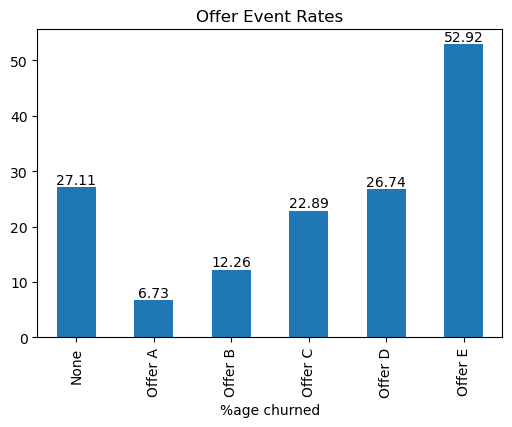

association:  0.2615296718715408


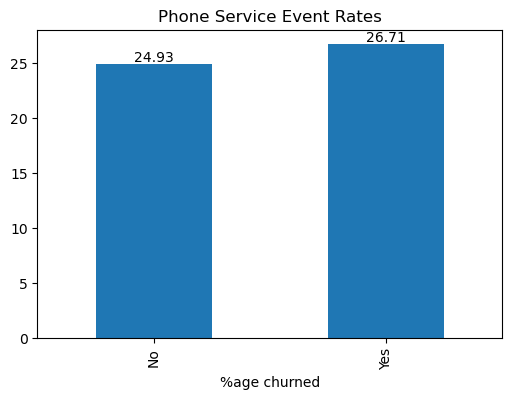

association:  0.011941980029003072


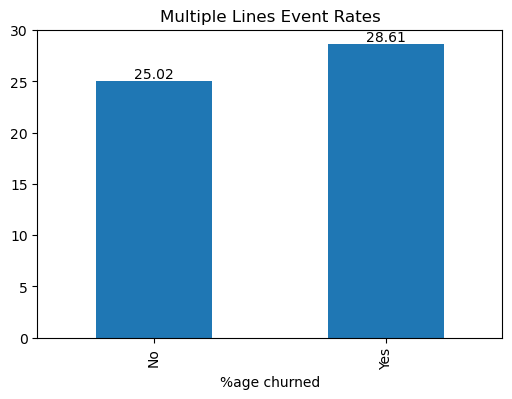

association:  0.04010212769982617


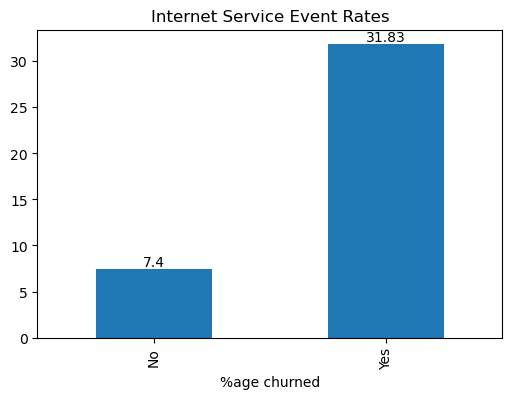

association:  0.22789044975609346


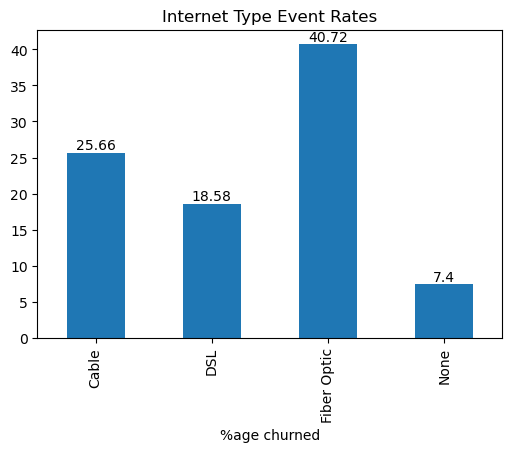

association:  0.30468723521251284


In [253]:
associations_all = {}
for col in df_services.columns:
    if 'churn' in col.lower():
        continue
    else:
        try:
            plot_event_rate(col)
        except Exception as e:
            print(col)
    associations_all[col] = get_association(col)
    print('association: ', get_association(col))

# pd.DataFrame(associations_all)

Offer, Internet Service and Internet Types have high associations and effect event rates

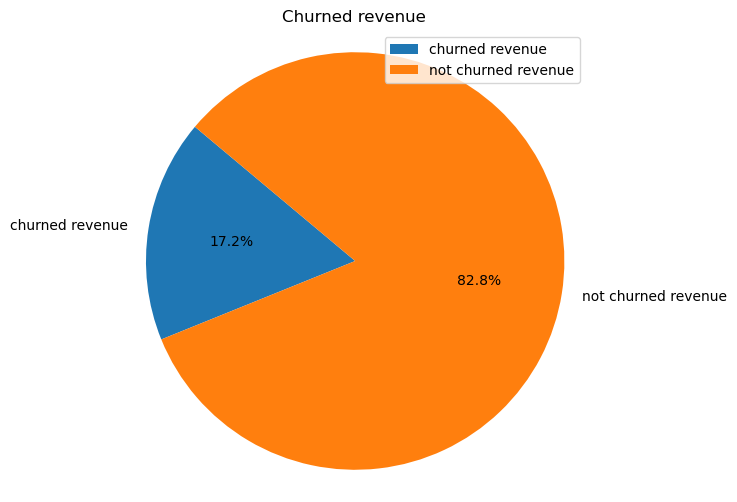

Total Revenue =  21371131.69


In [265]:
# total revenue loss by churn

df_churned['Total Revenue'].sum()
df_not_churned['Total Revenue'].sum()

labels = ['churned revenue','not churned revenue']
sizes = [df_churned['Total Revenue'].sum(),df_not_churned['Total Revenue'].sum()]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Churned revenue')
plt.legend()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
print('Total Revenue = ',df_churned['Total Revenue'].sum()+df_not_churned['Total Revenue'].sum() )

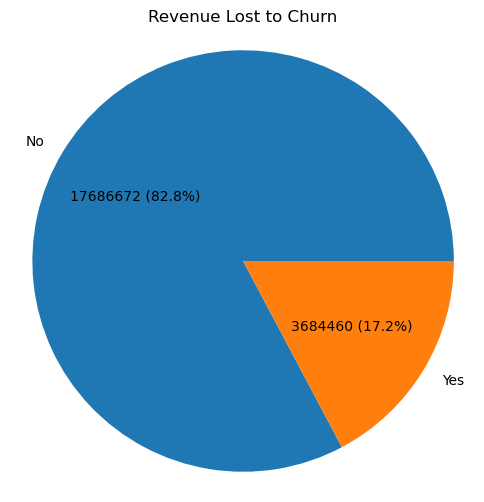

In [283]:
revenue_churned = df.groupby('Churn Label')['Total Revenue'].sum().reset_index()

# Plot pie chart with both percentages and values
plt.figure(figsize=(6, 6))
plt.pie(revenue_churned['Total Revenue'], labels=revenue_churned['Churn Label'], autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(df['Total Revenue']) / 100, p))
plt.title('Revenue Lost to Churn')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
